**PARAMS**

In [1]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set patience threshold
PATIENCE_ES = 8
PATIENCE_LR = 2

# Set maximum number of training epochs
EPOCHS = 150

# Set data split size for training and validation
SPLIT_TRAIN_VAL = 0.2

#Generic imports

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from tensorflow import keras


import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


#Load Data

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [4]:
# Set global random seed
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
prepath = '/content/drive/MyDrive/HomeworkANN/Homework2'

In [7]:
# Load the train_noOutlin data
data = np.load(prepath+"/Dataset/CopyPasteTest/Test04_Augmented00.npz")
dataVal = np.load(prepath+"/Dataset/train_val/noOutlieas_train_val.npz")
X_train = data['X_train']
y_train = data['y_train']

X_val = dataVal['X_val']
y_val = dataVal['y_val']


# Ensure correct data shapes and types
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension for grayscale
y_train = y_train.astype(np.int32)  # Ensure masks are integers
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (5010, 64, 128, 1, 1), y_train shape: (5010, 64, 128)


#Import the model

In [8]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from google.colab import files

In [15]:
model_filename = '/content/drive/MyDrive/HomeworkANN/Homework2/NetOutput/U-NET/Nico/best/56.1_small_unetplusplus_unetBlock_sqAndExc_ResDenseAttBridge_CrossBrAtt_classWeight_Test04.keras'

# Define input shape and number of classes
input_shape = (64, 128, 1)  # Grayscale images
num_classes = 5  # Number of segmentation classes

In [16]:

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


In [17]:
# Consolidated Loss Functions

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

# Weighted Dice Loss
def weighted_dice_loss(class_weights):
    def loss_fn(y_true, y_pred):
        # Convert sparse labels to one-hot encoding
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

        # Ensure both tensors are float32
        y_true_one_hot = tf.cast(y_true_one_hot, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Apply class weights
        weights = tf.gather(tf.constant(class_weights, dtype=tf.float32), tf.argmax(y_true_one_hot, axis=-1))
        weights = tf.expand_dims(weights, axis=-1)

        # Compute intersection and union
        intersection = tf.reduce_sum(weights * y_true_one_hot * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(weights * y_true_one_hot, axis=[1, 2, 3]) + tf.reduce_sum(weights * y_pred, axis=[1, 2, 3])

        # Dice coefficient
        dice = (2. * intersection + 1) / (union + 1)
        return 1 - dice
    return loss_fn

# Weighted Focal Loss
def weighted_focal_loss(class_weights, gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        # Ensure y_true is of integer type
        y_true = tf.cast(y_true, tf.int32)

        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Compute sparse categorical cross-entropy
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Gather the predicted probabilities corresponding to the true class
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)

        # Compute modulating factor
        modulating_factor = tf.pow(1 - probs, gamma)

        # Apply alpha scaling
        focal_loss = alpha * modulating_factor * ce

        # Apply class weights
        weights = tf.gather(tf.constant(class_weights, dtype=tf.float32), y_true)
        return tf.reduce_mean(focal_loss * weights)
    return loss_fn

# Weighted Boundary Loss
def weighted_boundary_loss(class_weights):
    def loss_fn(y_true, y_pred, y_boundary):
        # Convert sparse labels to one-hot encoding
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_true_one_hot = tf.cast(y_true_one_hot, tf.float32)

        # Boundary cross-entropy
        boundary_loss = tf.keras.losses.binary_crossentropy(y_boundary, y_pred)

        # Apply class weights
        weights = tf.gather(tf.constant(class_weights, dtype=tf.float32), tf.argmax(y_true_one_hot, axis=-1))
        return tf.reduce_mean(boundary_loss * weights)
    return loss_fn

# Weighted Sparse Categorical Cross-Entropy
def weighted_sparse_categorical_crossentropy(class_weights):
    def loss_fn(y_true, y_pred):
        # Ensure y_true has the correct dtype
        y_true = tf.cast(y_true, tf.int32)

        # Gather class weights for each pixel in the batch
        weights = tf.gather(tf.constant(class_weights, dtype=tf.float32), y_true)

        # Compute the sparse categorical cross-entropy loss
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Apply the weights to the loss
        return tf.reduce_mean(scce * weights)
    return loss_fn


In [18]:
class MergedLoss(Loss):
    def __init__(self, dice_weight=0.3, focal_weight=0.3, boundary_weight=0.2, weighted_loss_weight=0.2, class_weights=None, **kwargs):
        super(MergedLoss, self).__init__(**kwargs)
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.boundary_weight = boundary_weight
        self.weighted_loss_weight = weighted_loss_weight
        self.class_weights = class_weights

    def call(self, y_true, y_pred):
        # Compute individual losses
        dice = weighted_dice_loss(self.class_weights)(y_true, y_pred)
        focal = weighted_focal_loss(self.class_weights)(y_true, y_pred)
        boundary = 0  # Replace with weighted_boundary_loss(self.class_weights) if y_boundary is available
        weighted_loss = weighted_sparse_categorical_crossentropy(self.class_weights)(y_true, y_pred)

        # Combine losses
        return (
            self.dice_weight * dice +
            self.focal_weight * focal +
            self.boundary_weight * boundary +
            self.weighted_loss_weight * weighted_loss
        )


In [19]:
class_weights = [0.9, 1.0, 1.5, 1.5, 2]

In [20]:
model = tfk.models.load_model(
    model_filename, compile=False
)

print(f"Model loaded from {model_filename}")

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
merged_loss_fn = MergedLoss(
    dice_weight=0.3,
    focal_weight=0.3,
    boundary_weight=0.2,
    weighted_loss_weight=0.2,
    class_weights=class_weights
)

model.compile(
    optimizer=optimizer,
    loss=merged_loss_fn,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

Model loaded from /content/drive/MyDrive/HomeworkANN/Homework2/NetOutput/U-NET/Nico/best/56.1_small_unetplusplus_unetBlock_sqAndExc_ResDenseAttBridge_CrossBrAtt_classWeight_Test04.keras


#Train

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=PATIENCE_LR,
    min_lr=1e-8,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE_ES,
    restore_best_weights=True
)


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 747ms/step - accuracy: 0.7745 - loss: 0.2476 - mean_iou: 0.6444 - val_accuracy: 0.7753 - val_loss: 0.2323 - val_mean_iou: 0.5072 - learning_rate: 1.0000e-04
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 216ms/step - accuracy: 0.7790 - loss: 0.2438 - mean_iou: 0.6503 - val_accuracy: 0.7737 - val_loss: 0.2320 - val_mean_iou: 0.5017 - learning_rate: 1.0000e-04
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7839 - loss: 0.2360 - mean_iou: 0.6574
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.7839 - loss: 0.2361 - mean_iou: 0.6574 - val_accuracy: 0.7731 - val_loss: 0.2302 - val_mean_iou: 0.5056 - learning_rate: 1.0000e-04
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - accuracy: 0.7901 - loss: 0.2292 - mean_iou: 0.6642 - val_accuracy: 0.7897 - val_loss: 0.2177 - val_mean_iou: 0.5154 - learning_rate: 5.0000e-05
Epoch 5/150
79/79 ━━━━━━━━━━━━

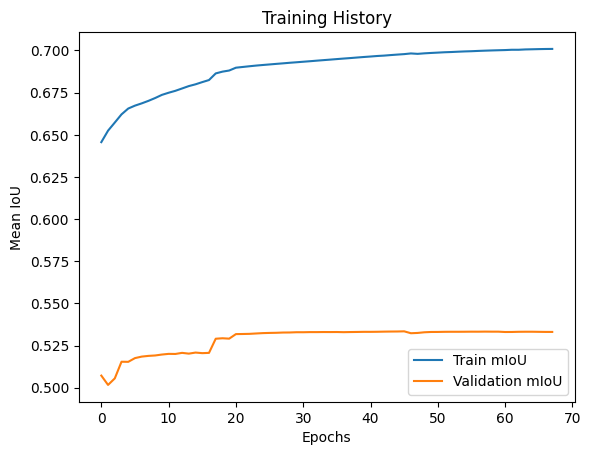

In [22]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping]
)


# Plot training history
plt.plot(history.history['mean_iou'], label='Train mIoU')
plt.plot(history.history['val_mean_iou'], label='Validation mIoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.title('Training History')
plt.show()

In [23]:
import os

# Verifica se la cartella esiste, altrimenti creala
output_dir = prepath + "/NetOutput/U-NET/Nico"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Salva il modello
outputfile = output_dir + "/small_unetplusplus_unetBlock_sqAndExc_ResDenseAttBridge_CrossBrAtt_classWeight_Test04_FineTuning.keras"
model.save(outputfile)
print(f"Model saved as {outputfile}")


Model saved as /content/drive/MyDrive/HomeworkANN/Homework2/NetOutput/U-NET/Nico/small_unetplusplus_unetBlock_sqAndExc_ResDenseAttBridge_CrossBrAtt_classWeight_Test04_FineTuning.keras
